In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import ncdl
import os
import ncdl.nn as ncnn
from PIL import Image
from typing import Optional, Callable
from ncdl.nn.functional.downsample import downsample
from ncdl.nn.functional.upsample import upsample
from ncdl import pad_like
from utility import visualize_lattice
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

image_transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((284, 284)),
    transforms.ToTensor()
])

train_image_dir = '/path/to/the/data'
train_mask_dir = '/path/to/the/data'
test_image_dir = '/path/to/the/data'
test_mask_dir = '/path/to/the/data'

batch_size = 8

train_dataset = CustomDataset(train_image_dir, train_mask_dir, image_transform=image_transform, mask_transform=mask_transform)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(test_image_dir, test_mask_dir, image_transform=image_transform, mask_transform=mask_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LatticeNormalizationWrapper class is from the following:
'''Horacsek, J. (2023). *Non-Cartesian Deep Learning (NCDL)* [Source code]. GitHub. 
   https://github.com/jjh13/NCDL/tree/master/ncdl'''
class LatticeNormalizationWrapper(nn.Module):
    def __init__(self, lattice, channels, normalization):
        super(LatticeNormalizationWrapper, self).__init__()
        assert normalization in [None, 'bn', 'gn', 'in']
        if normalization is None:
            self.module = nn.Identity()
        elif normalization == 'bn':
            self.module = ncnn.LatticeBatchNorm(lattice, channels)
        elif normalization == 'in':
            self.module = ncnn.LatticeInstanceNorm(lattice, channels)
        elif normalization == 'gn':
            group_size = [group_size for group_size in [8,4,2,1] if channels % group_size == 0][0]
            self.module = ncnn.LatticeGroupNorm(lattice, channels//group_size, channels)

    def forward(self, x):
        return self.module(x)
    
def increase_spatial_dimensions(image, pad_value=0):
    padded_image = nn.functional.pad(image, (1, 1, 1, 1), mode='constant', value=pad_value)
    return padded_image

    
class NCDL(nn.Module):
    def __init__(self, lattice: ncdl.Lattice, num_classes=10):
        super().__init__()
        
        self.lattice = lattice

        if lattice == ncdl.Lattice("qc"):
            stencil = ncdl.Stencil([
                (1, 1), (2, 2), (3, 1), (1, 3), (3, 3), (0, 2), (2, 0), (2, 4), (4, 2)

            ], lattice, center=(2, 2))
            
        # encoder
        self.layer2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        self.layer3 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=64, channels_out=96, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 96, 'bn'),
            ncnn.LeakyReLU())
        self.layer4 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.Conv2d(96, 144, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(144),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        self.layer5 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=144, channels_out=216, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 216, 'bn'),
            ncnn.LeakyReLU())
        self.layer6 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.Conv2d(216, 324, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(324),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        self.layer7 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=324, channels_out=486, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 486, 'bn'),
            ncnn.LeakyReLU())
        self.layer8 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.Conv2d(486, 729, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(729),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout())
        self.layer9 = nn.Sequential(
            ncnn.LatticePad(lattice, stencil),
            ncnn.LatticeConvolution(lattice, channels_in=729, channels_out=1024, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 1024, 'bn'),
            ncnn.LeakyReLU())
        
        
        # decoder
        self.layer17 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.ConvTranspose2d(1024, 729, kernel_size=4, stride=3, padding=0, output_padding=1))
        self.layer17sub = nn.Sequential(
            nn.Conv2d(1458, 729, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(729),
            nn.LeakyReLU(),
            nn.Dropout())
        self.layer18 = nn.Sequential(
            ncnn.LatticeConvolution(lattice, channels_in=729, channels_out=486, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 486, 'bn'),
            ncnn.LeakyReLU())
        self.layer19 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.ConvTranspose2d(486, 324, kernel_size=4, stride=3, padding=0, output_padding=1))
        self.layer19sub = nn.Sequential(
            nn.Conv2d(648, 324, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(324),
            nn.LeakyReLU(),
            nn.Dropout())
        self.layer20 = nn.Sequential(
            ncnn.LatticeConvolution(lattice, channels_in=324, channels_out=216, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 216, 'bn'),
            ncnn.LeakyReLU())
        self.layer21 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.ConvTranspose2d(216, 144, kernel_size=4, stride=3, padding=0, output_padding=1))
        self.layer21sub = nn.Sequential(
            nn.Conv2d(288, 144, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(144),
            nn.LeakyReLU(),
            nn.Dropout())
        self.layer22 = nn.Sequential(
            ncnn.LatticeConvolution(lattice, channels_in=144, channels_out=96, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 96, 'bn'),
            ncnn.LeakyReLU())
        self.layer26 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.ConvTranspose2d(96, 64, kernel_size=4, stride=3, padding=0, output_padding=1))
        self.layer26sub = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout())
        self.layer27 = nn.Sequential(
            ncnn.LatticeConvolution(lattice, channels_in=64, channels_out=1, stencil=stencil, bias=False),
            LatticeNormalizationWrapper(lattice, 1, 'bn'),
            ncnn.LeakyReLU())
        
        self.layer28 = nn.Sequential(
            ncnn.LatticeUnwrap(),
            nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(),
            nn.Dropout())

    def forward(self, x):
        layer = ncnn.LatticeWrap()
        out4 = self.layer2(x)
        out = layer(out4)
        restore1 = downsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = self.layer3(restore1)
        out3 = self.layer4(out)
        out = layer(out3)
        restore2 = downsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = self.layer5(restore2)
        out2 = self.layer6(out)
        out = layer(out2)
        restore3 = downsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = self.layer7(restore3)
        out1 = self.layer8(out)
        out = layer(out1)
        restore4 = downsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = self.layer9(restore4)

        out = self.layer17(out)
        out = nn.functional.interpolate(out, size=(4, 4), mode='bilinear', align_corners=False)
        out = torch.cat([out, out1], dim=1)
        out = self.layer17sub(out)
        out = layer(out)
        out = upsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = pad_like(out, restore4)
        out = self.layer18(out)
        out = self.layer19(out)
        out = nn.functional.interpolate(out, size=(18, 18), mode='bilinear', align_corners=False)
        out = torch.cat([out, out2], dim=1)
        out = self.layer19sub(out)
        out = layer(out)
        out = upsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = pad_like(out, restore3)
        out = self.layer20(out)
        out = self.layer21(out)
        out = nn.functional.interpolate(out, size=(71, 71), mode='bilinear', align_corners=False)
        out = torch.cat([out, out3], dim=1)
        out = self.layer21sub(out)
        out = layer(out)
        out = upsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = pad_like(out, restore2)
        out = self.layer22(out)
        out = self.layer26(out)
        out = nn.functional.interpolate(out, size=(286, 286), mode='bilinear', align_corners=False)
        out = torch.cat([out, out4], dim=1)
        out = self.layer26sub(out)
        out = layer(out)
        out = upsample(out, np.array([[-1, 1], [1, 1]], dtype='int'))
        out = pad_like(out, restore1)
        out = self.layer27(out)
        
        out = self.layer28(out)
        return out
    
    
lattice = ncdl.Lattice("qc")
model = NCDL(lattice)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

def calculate_pixel_accuracy(outputs, masks):
    outputs = torch.sigmoid(outputs)  
    preds = outputs > 0.5  
    correct = (preds == masks).sum().item()
    total = torch.numel(preds)
    return correct / total


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        if outputs.shape != masks.shape:
            print(f"Shape mismatch: outputs {outputs.shape}, masks {masks.shape}")
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in valid_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(valid_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")

Number of parameters: 43334903
Number of trainable parameters: 43334903


/home/sua.lim/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/sua.lim/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/sua.lim/work/ncdl/NCDL/ncdl/nn/functional/convolution.py:79: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_

Epoch 1/10, Train Loss: 0.27228775059924115, Validation Loss: 0.25676502706880255
Epoch 2/10, Train Loss: 0.24918286267098383, Validation Loss: 0.24209737890704547
Epoch 3/10, Train Loss: 0.24387710164060075, Validation Loss: 0.24586038182697026
Epoch 4/10, Train Loss: 0.24133528490159997, Validation Loss: 0.23753784352569218
Epoch 5/10, Train Loss: 0.2393692701518444, Validation Loss: 0.23576221412392023
Epoch 6/10, Train Loss: 0.23782339465853927, Validation Loss: 0.23402543395616432
Epoch 7/10, Train Loss: 0.23603996786795337, Validation Loss: 0.2322695960083279
Epoch 8/10, Train Loss: 0.23562166219735814, Validation Loss: 0.2312992051031917
Epoch 9/10, Train Loss: 0.23350327228548176, Validation Loss: 0.2305092071469926
Epoch 10/10, Train Loss: 0.23197982429109676, Validation Loss: 0.2291510860784359


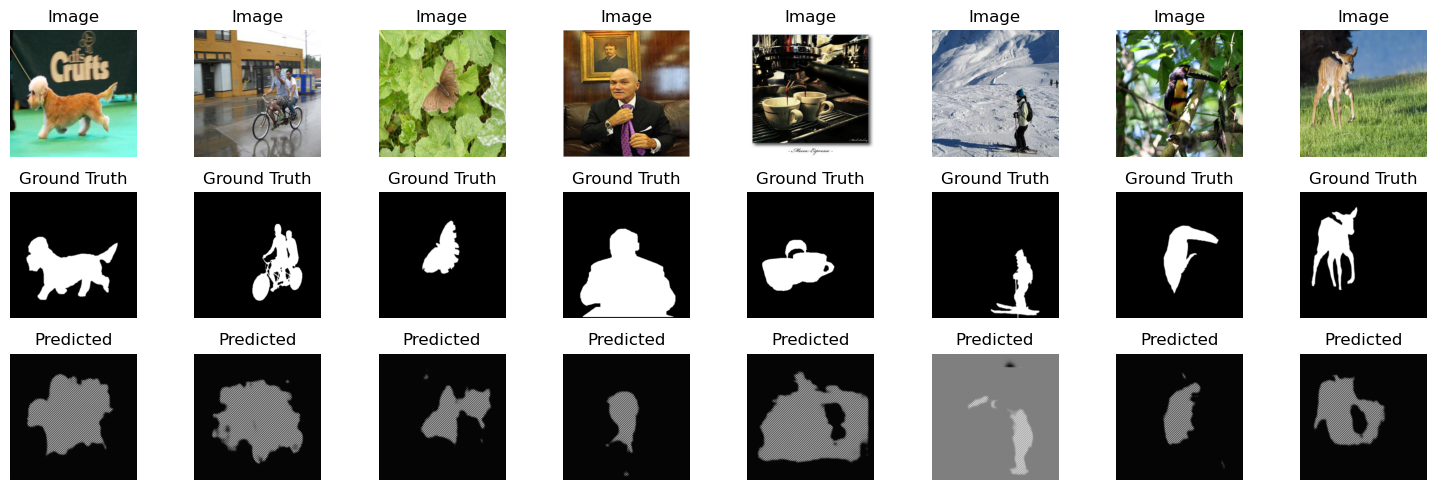

Test Loss: 0.0004343651138612725


In [3]:
def visualize_predictions(images, masks, outputs, idx):
    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    masks = masks.cpu().numpy()
    outputs = torch.sigmoid(outputs).cpu().numpy()

    fig, axs = plt.subplots(3, len(images), figsize=(15, 5))

    for i in range(len(images)):
        axs[0, i].imshow(images[i])
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')
        
        axs[1, i].imshow(masks[i][0], cmap='gray')
        axs[1, i].set_title('Ground Truth')
        axs[1, i].axis('off')
        
        axs[2, i].imshow(outputs[i][0], cmap='gray')
        axs[2, i].set_title('Predicted')
        axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

model.eval()
with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)
        
        if idx == 0:
            visualize_predictions(images, masks, outputs, idx)
            break


test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")